In [2]:
!pip install matplotlib
!pip install sklearn
!pip install pickle-mixin
!pip install lightgbm

  Stored in directory: /home/philmassie/snap/jupyter/6/.cache/pip/wheels/cd/05/42/71de70fa36b9cbb7657bb5793a16f8028c1cdc1bdd3b8e1ac3
Successfully built pickle-mixin


In [1]:
from IPython import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt
%matplotlib inline
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
from sklearn import metrics
from sklearn import ensemble
from sklearn import feature_extraction, preprocessing, model_selection
from sklearn import linear_model
import pickle

def calc_gini(y_true, y_score):
    if np.unique(y_true).shape[0] == 1:
        return np.nan
    return 2*metrics.roc_auc_score(y_true, y_score) - 1

# for debugging
from IPython.core.debugger import set_trace

In [3]:
!ls

submission-notes  test.csv	Victory solution - Veegaaa.ipynb
submissions	  training.csv


In [4]:
# os.listdir('submissions')

## Data Load

In [5]:
df_source = pd.read_csv('training.csv')
df_source.columns
df_source.head()
df_source.shape

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'Amount', 'Value',
       'TransactionStartTime', 'PricingStrategy', 'FraudResult'],
      dtype='object')

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


(95662, 16)

In [6]:
df_submission = pd.read_csv('test.csv')
df_submission.columns
df_submission.head()
df_submission.shape

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'Amount', 'Value',
       'TransactionStartTime', 'PricingStrategy'],
      dtype='object')

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
0,TransactionId_50600,BatchId_35028,AccountId_2441,SubscriptionId_4426,CustomerId_2857,UGX,256,ProviderId_5,ProductId_3,airtime,ChannelId_3,1000.0,1000,2019-02-13T10:01:40Z,4
1,TransactionId_95109,BatchId_45139,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,ProviderId_5,ProductId_15,financial_services,ChannelId_3,2000.0,2000,2019-02-13T10:02:12Z,2
2,TransactionId_47357,BatchId_74887,AccountId_4841,SubscriptionId_3829,CustomerId_2857,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-50.0,50,2019-02-13T10:02:30Z,2
3,TransactionId_28185,BatchId_11025,AccountId_2685,SubscriptionId_4626,CustomerId_3105,UGX,256,ProviderId_5,ProductId_10,airtime,ChannelId_3,3000.0,3000,2019-02-13T10:02:38Z,4
4,TransactionId_22140,BatchId_29804,AccountId_4841,SubscriptionId_3829,CustomerId_3105,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-60.0,60,2019-02-13T10:02:58Z,2


(45019, 15)

In [7]:
def find_number_unique_CAS_id(df_src,
                              CustomerId,
                              AccountId,
                              SubscriptionId
                             ):
    df_cust = df_src.query(f"CustomerId == {CustomerId}")
    df_acc = df_src.query(f"AccountId == {AccountId}")
    df_sub = df_src.query(f"SubscriptionId == {SubscriptionId}")

    print(r"For CustomerId")
    print("AccountId", df_cust['AccountId'].unique().shape[0])
    print("SubscriptionId", df_cust['SubscriptionId'].unique().shape[0])
    
    print(r"For AccountId")
    print("CustomerId", df_acc['CustomerId'].unique().shape[0])
    print("SubscriptionId", df_acc['SubscriptionId'].unique().shape[0])
    
    print(r"For SubscriptionId")
    print("CustomerId", df_sub['CustomerId'].unique().shape[0])
    print("AccountId", df_sub['AccountId'].unique().shape[0])
    
def get_source_with_CPPP(df_src,ChannelId,PricingStrategy,ProductId,ProviderId):
    return df_src.query(f"ChannelId == {ChannelId} and \
        PricingStrategy == {PricingStrategy} and \
        ProductId == {ProductId} and \
        ProviderId == {ProviderId}")

def get_all_transactions_given_CAS(df_src, CustomerId, AccountId, SubscriptionId):
    print(CustomerId)
    display(df_src.query(f"CustomerId == {CustomerId}"))
    print(AccountId)
    display(df_src.query(f"AccountId == {AccountId}"))
    print(SubscriptionId)
    display(df_src.query(f"SubscriptionId == {SubscriptionId}"))

In [8]:
def make_submission(y_subm_pred,
                    sample_subm_path='submissions/sample_submission.csv',
                    csv_filepath = None,
                    note=None,
                    note_file_path=None
                   ):
    df_sample_submission = pd.read_csv(sample_subm_path)
    df_sample_submission['FraudResult'] = y_subm_pred
    
    if os.path.exists(csv_filepath) or os.path.exists(note_file_path):
        print("ERROR! Submission already exists.")
    else:
        with open(note_file_path, 'w') as f:
            f.write(note)
        df_sample_submission.to_csv(csv_filepath, index=False)
        print("Submission created")

### Preprocessing

In [9]:
def is_index_unique_arange(df_src):
    return (df_src.index == np.arange(df_src.shape[0])).all()

is_index_unique_arange(df_source)
is_index_unique_arange(df_submission)

True

True

In [10]:
def drop_constant_features(df_train, df_test):
    constant_cols = df_train.columns[df_train.nunique(dropna=False) == 1]
    if constant_cols.shape[0] == 0:
        print("0 contant cols")
    elif (df_test[constant_cols].nunique() == 1).all():
        df_train.drop(constant_cols, axis=1, inplace=True)
        df_test.drop(constant_cols, axis=1, inplace=True)
        print(len(constant_cols), "constant columns dropped")
    else:
        non_constant_test_cols = constant_cols[df_test[constant_cols].nunique() != 1]
        print(non_constant_test_cols, "columns are not CONST in df_test")

drop_constant_features(df_source, df_submission)

2 constant columns dropped


In [11]:
df_source.nunique(dropna=False)
df_source.shape

TransactionId           95662
BatchId                 94809
AccountId                3633
SubscriptionId           3627
CustomerId               3742
ProviderId                  6
ProductId                  23
ProductCategory             9
ChannelId                   4
Amount                   1676
Value                    1517
TransactionStartTime    94556
PricingStrategy             4
FraudResult                 2
dtype: int64

(95662, 14)

In [12]:
df_source.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [13]:
df_source.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Amount',
       'Value', 'TransactionStartTime', 'PricingStrategy', 'FraudResult'],
      dtype='object')

In [14]:
for col in ['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'ProviderId', 'ProductId', 'ChannelId']:
    df_source[col] = df_source[col].str.lstrip(col + '_').astype(np.int32)
    df_submission[col] = df_submission[col].str.lstrip(col + '_').astype(np.int32)

In [15]:
df_source.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,76871,36123,3957,887,4406,6,10,airtime,3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,73770,15642,4841,3829,4406,4,6,financial_services,2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,26203,53941,4229,222,4683,6,1,airtime,3,500.0,500,2018-11-15T02:44:21Z,2,0
3,380,102363,648,2185,988,1,21,utility_bill,3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,28195,38780,4841,3829,988,4,6,financial_services,2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [16]:
df_source.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Amount',
       'Value', 'TransactionStartTime', 'PricingStrategy', 'FraudResult'],
      dtype='object')

In [17]:
def preprocess(df):
    df['TransactionStartTime'] = df['TransactionStartTime'].astype(np.datetime64)
    
preprocess(df_source)
preprocess(df_submission)

In [18]:
df_source.head()
df_submission.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,76871,36123,3957,887,4406,6,10,airtime,3,1000.0,1000,2018-11-15 02:18:49,2,0
1,73770,15642,4841,3829,4406,4,6,financial_services,2,-20.0,20,2018-11-15 02:19:08,2,0
2,26203,53941,4229,222,4683,6,1,airtime,3,500.0,500,2018-11-15 02:44:21,2,0
3,380,102363,648,2185,988,1,21,utility_bill,3,20000.0,21800,2018-11-15 03:32:55,2,0
4,28195,38780,4841,3829,988,4,6,financial_services,2,-644.0,644,2018-11-15 03:34:21,2,0


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
0,50600,35028,2441,4426,2857,5,3,airtime,3,1000.0,1000,2019-02-13 10:01:40,4
1,95109,45139,3439,2643,3874,5,15,financial_services,3,2000.0,2000,2019-02-13 10:02:12,2
2,47357,74887,4841,3829,2857,4,6,financial_services,2,-50.0,50,2019-02-13 10:02:30,2
3,28185,11025,2685,4626,3105,5,10,airtime,3,3000.0,3000,2019-02-13 10:02:38,4
4,22140,29804,4841,3829,3105,4,6,financial_services,2,-60.0,60,2019-02-13 10:02:58,2


In [19]:
df_submission['FraudResult'] = np.nan
df_source['SampleType'] = 'Train'
df_submission['SampleType'] = 'Test'

In [20]:
df_source = df_source.reindex(sorted(df_source.columns), axis=1)
df_submission = df_submission.reindex(sorted(df_source.columns), axis=1)

In [21]:
df_all = pd.concat((df_source, df_submission)).reset_index(drop=True)
df_all.head()

,AccountId,Amount,BatchId,ChannelId,CustomerId,FraudResult,PricingStrategy,ProductCategory,ProductId,ProviderId,SampleType,SubscriptionId,TransactionId,TransactionStartTime,Value
0,3957,1000.0,36123,3,4406,0.0,2,airtime,10,6,Train,887,76871,2018-11-15 02:18:49,1000
1,4841,-20.0,15642,2,4406,0.0,2,financial_services,6,4,Train,3829,73770,2018-11-15 02:19:08,20
2,4229,500.0,53941,3,4683,0.0,2,airtime,1,6,Train,222,26203,2018-11-15 02:44:21,500
3,648,20000.0,102363,3,988,0.0,2,utility_bill,21,1,Train,2185,380,2018-11-15 03:32:55,21800
4,4841,-644.0,38780,2,988,0.0,2,financial_services,6,4,Train,3829,28195,2018-11-15 03:34:21,644


In [22]:
df_source['Fraud_Sure'] = 1
df_submission['Fraud_Sure'] = np.nan

In [23]:
col_order = ['CustomerId', 'AccountId', 'SubscriptionId', 'BatchId', 'ChannelId',
       'FraudResult', 'Fraud_Sure', 'PricingStrategy', 'ProductCategory', 'ProductId',
       'ProviderId', 'SampleType', 'TransactionId',
       'TransactionStartTime', 'Value', 'Amount']
df_source = df_source[col_order]
df_submission = df_submission[col_order]

### EDA

In [24]:
categ_features = ['ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'PricingStrategy']
real_features = ['Amount', 'Value']
time_features = ['TransactionStartTime']

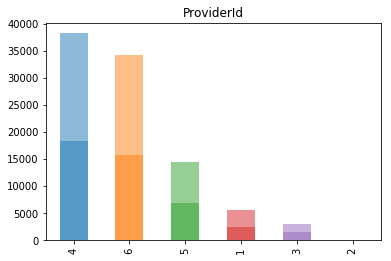

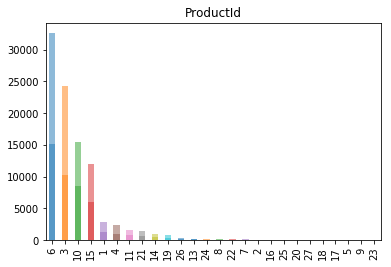

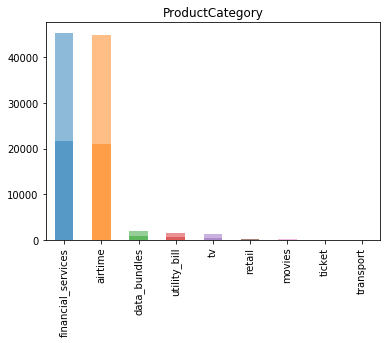

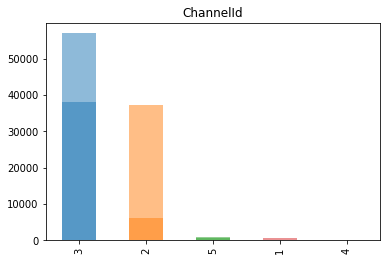

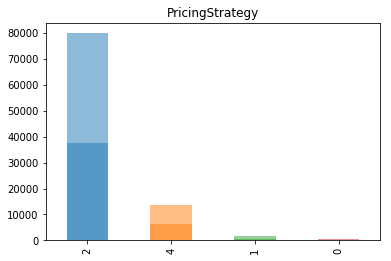

In [25]:
for feature in categ_features:
    _ = plt.figure()
    
    _ = plt.title(feature)
    _ = df_source[feature].value_counts().plot(kind='bar', alpha=0.5)
    _ = df_submission[feature].value_counts().plot(kind='bar', alpha=0.5)

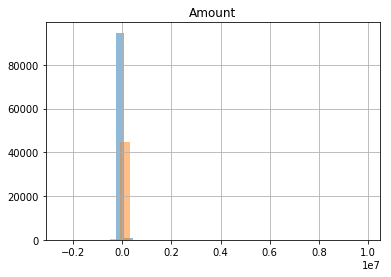

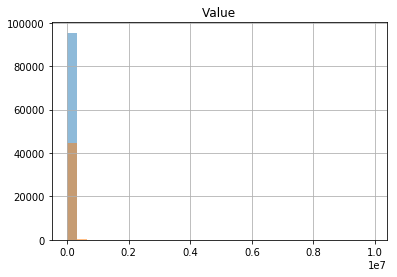

In [26]:
for feature in real_features:
    _ = plt.figure()
    _ = plt.title(feature)
    _ = df_source[feature].hist(bins=30, alpha = 0.5)
    _ = df_submission[feature].hist(bins=30, alpha = 0.5)


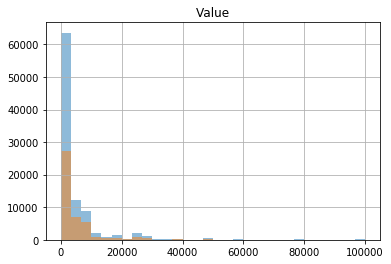

In [27]:
feature = 'Value'
trld = 0.1*(10**6)
_ = plt.figure()
_ = plt.title(feature)
_ = df_source.query(feature + " <= " + str(trld))[feature].hist(bins=30, alpha = 0.5)
_ = df_submission.query(feature + " <= " + str(trld))[feature].hist(bins=30, alpha = 0.5)

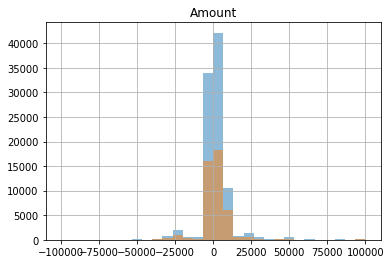

In [28]:
feature = 'Amount'
r_trld = 0.1*(10**6)
l_trld = -100000
_ = plt.figure()
_ = plt.title(feature)
_ = df_source.query(feature + " >= " + str(l_trld))\
            .query(feature + " <= " + str(r_trld))[feature].hist(bins=30, alpha = 0.5)
_ = df_submission.query(feature + " >= " + str(l_trld))\
            .query(feature + " <= " + str(r_trld))[feature].hist(bins=30, alpha = 0.5)

In [29]:
df_source.columns

Index(['CustomerId', 'AccountId', 'SubscriptionId', 'BatchId', 'ChannelId',
       'FraudResult', 'Fraud_Sure', 'PricingStrategy', 'ProductCategory',
       'ProductId', 'ProviderId', 'SampleType', 'TransactionId',
       'TransactionStartTime', 'Value', 'Amount'],
      dtype='object')

<Figure size 720x720 with 0 Axes>

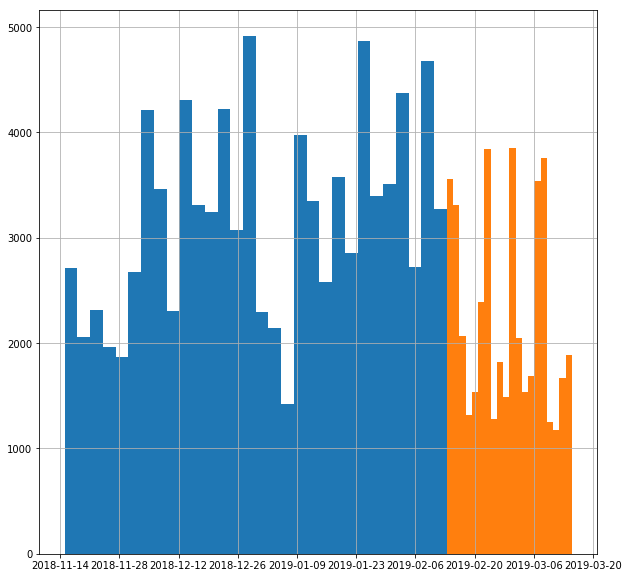

In [30]:
plt.figure(figsize=(10,10))
df_source['TransactionStartTime'].hist(bins = 30)
df_submission['TransactionStartTime'].hist(bins = 20)

In [31]:
df_source.columns

Index(['CustomerId', 'AccountId', 'SubscriptionId', 'BatchId', 'ChannelId',
       'FraudResult', 'Fraud_Sure', 'PricingStrategy', 'ProductCategory',
       'ProductId', 'ProviderId', 'SampleType', 'TransactionId',
       'TransactionStartTime', 'Value', 'Amount'],
      dtype='object')

In [32]:
id_features = ['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId']
for feature in id_features:
    f"Number of unique values of {feature} in samples", df_source[feature].unique().shape, df_submission[feature].unique().shape
    feature, np.intersect1d(df_source[feature], df_submission[feature]).shape

('Number of unique values of TransactionId in samples', (95662,), (45019,))

('TransactionId', (0,))

('Number of unique values of BatchId in samples', (94809,), (44684,))

('BatchId', (0,))

('Number of unique values of AccountId in samples', (3633,), (2471,))

('AccountId', (1263,))

('Number of unique values of SubscriptionId in samples', (3627,), (2470,))

('SubscriptionId', (1261,))

('Number of unique values of CustomerId in samples', (3742,), (5018,))

('CustomerId', (1281,))

In [33]:
df_source.shape
df_submission.shape

(95662, 16)

(45019, 16)

In [34]:
df_source.head()

,CustomerId,AccountId,SubscriptionId,BatchId,ChannelId,FraudResult,Fraud_Sure,PricingStrategy,ProductCategory,ProductId,ProviderId,SampleType,TransactionId,TransactionStartTime,Value,Amount
0,4406,3957,887,36123,3,0,1,2,airtime,10,6,Train,76871,2018-11-15 02:18:49,1000,1000.0
1,4406,4841,3829,15642,2,0,1,2,financial_services,6,4,Train,73770,2018-11-15 02:19:08,20,-20.0
2,4683,4229,222,53941,3,0,1,2,airtime,1,6,Train,26203,2018-11-15 02:44:21,500,500.0
3,988,648,2185,102363,3,0,1,2,utility_bill,21,1,Train,380,2018-11-15 03:32:55,21800,20000.0
4,988,4841,3829,38780,2,0,1,2,financial_services,6,4,Train,28195,2018-11-15 03:34:21,644,-644.0


## Baseline model

In [35]:
categ_features = ['ProviderId', 'ProductId', 'ChannelId', 'PricingStrategy']

In [36]:
full_features_list = ['ProviderId', 'ProductId', 
#                       'ProductCategory',
                      'ChannelId', 'Amount',
       'Value', 'PricingStrategy']
df_source[categ_features] = df_source[categ_features].astype('int')

In [37]:
np.random.seed(1)

y_target_name = 'FraudResult'
df_train, df_test = model_selection.train_test_split(df_source, test_size=0.33)
X_train = df_train.drop(y_target_name, axis=1)[full_features_list]
y_train = df_train[y_target_name].values
X_test = df_test.drop(y_target_name, axis=1)[full_features_list]
y_test = df_test[y_target_name].values

X_submission = df_submission[full_features_list]

In [38]:
from sklearn import tree
DT = tree.DecisionTreeClassifier(min_samples_split=20, min_samples_leaf=10, max_depth=7)
_ = DT.fit(X_train, y_train)
metrics.f1_score(y_train, DT.predict(X_train))
metrics.f1_score(y_test, DT.predict(X_test))

0.9021276595744682

0.8396946564885497

In [39]:
fit_params={
    'objective': 'binary',
    "metric" : 'binary_logloss', 
#             "eval_set" : [(X_test,y_test)],
#             'eval_names': ['valid'],
            'verbose': 5,
    'max_depth':5
#             'feature_name': 'auto', # that's actually the default
#             'categorical_feature': 'auto' # that's actually the default
           }

In [40]:
import lightgbm as lgb
model = lgb.LGBMClassifier(n_estimators=100,
                           learning_rate=0.0001,
                           max_depth=2,
                           boosting_type='gbdt',
                           objective='binary',
                           metric='auc',
                           seed=4,
                           num_leaves=7,
                           n_jobs=-1,
                           random_state=42,
                           asfasfsaf=1
                          )

In [41]:
model.fit(X=X_train, 
          y=y_train,
          eval_set=[(X_test,y_test)],
          verbose=3,
          early_stopping_rounds=100,
          feature_name=full_features_list,
          categorical_feature=categ_features
         )
# cv_val = model.predict_proba(X_val)[:,1]
#Save LightGBM Model
# save_to = '{}{}_fold{}.txt'.format(lgb_path, name, counter+1)
# model.booster_.save_model(save_to)
# del X_fit, y_fit, X_val, y_val

/home/veegaaa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ChannelId', 'PricingStrategy', 'ProductId', 'ProviderId']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[3]	valid_0's auc: 0.947501
[6]	valid_0's auc: 0.984459
[9]	valid_0's auc: 0.984459
[12]	valid_0's auc: 0.984459
[15]	valid_0's auc: 0.984535
[18]	valid_0's auc: 0.984535
[21]	valid_0's auc: 0.984535
[24]	valid_0's auc: 0.984535
[27]	valid_0's auc: 0.984535
[30]	valid_0's auc: 0.984535
[33]	valid_0's auc: 0.984535
[36]	valid_0's auc: 0.984535
[39]	valid_0's auc: 0.984535
[42]	valid_0's auc: 0.984535
[45]	valid_0's auc: 0.984535
[48]	valid_0's auc: 0.984535
[51]	valid_0's auc: 0.984535
[54]	valid_0's auc: 0.984535
[57]	valid_0's auc: 0.984535
[60]	valid_0's auc: 0.984535
[63]	valid_0's auc: 0.984535
[66]	valid_0's auc: 0.984535
[69]	valid_0's auc: 0.984535
[72]	valid_0's auc: 0.984535
[75]	valid_0's auc: 0.984535
[78]	valid_0's auc: 0.984535
[81]	valid_0's auc: 0.984535
[84]	valid_0's auc: 0.984535
[87]	valid_0's auc: 0.984535
[90]	valid_0's auc: 0.984535
[93]	valid_0's auc: 0.984535
[96]	valid_0's auc: 0.984535
[99]	valid_0

LGBMClassifier(asfasfsaf=1, boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, importance_type='split',
        learning_rate=0.0001, max_depth=2, metric='auc',
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=7, objective='binary',
        random_state=42, reg_alpha=0.0, reg_lambda=0.0, seed=4,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

In [42]:
y_test.mean()
model.predict_proba(X_test)[:,1].mean()

0.0021223352022553773

0.001966354378194459

In [43]:
full_features_list

['ProviderId', 'ProductId', 'ChannelId', 'Amount', 'Value', 'PricingStrategy']

In [44]:
np.unique(model.predict_proba(X_test)[:,1])

array([0.00196328, 0.00198661, 0.00205896, 0.00276008, 0.00276174,
       0.00279885, 0.00334751])

## Farther Analysis

### Fraud Investigation

In [45]:
df_fraud = df_source.query("FraudResult == 1")
df_fraud.head()
df_fraud.shape

,CustomerId,AccountId,SubscriptionId,BatchId,ChannelId,FraudResult,Fraud_Sure,PricingStrategy,ProductCategory,ProductId,ProviderId,SampleType,TransactionId,TransactionStartTime,Value,Amount
131,4275,3832,4161,93685,3,1,1,0,financial_services,15,3,Train,60873,2018-11-15 08:04:51,700000,700000.0
146,7414,2366,4834,125553,1,1,1,2,financial_services,9,5,Train,28016,2018-11-15 08:20:09,725000,725000.0
155,4275,3832,4161,10381,3,1,1,0,financial_services,15,3,Train,1149,2018-11-15 08:31:57,700000,700000.0
2376,4134,3692,3451,52644,3,1,1,0,financial_services,15,1,Train,136904,2018-11-17 09:15:23,700000,700000.0
2452,4275,3832,4161,54481,3,1,1,0,financial_services,15,3,Train,88818,2018-11-17 11:49:46,700000,700000.0


(193, 16)

In [46]:
pd.DataFrame({'source':df_source.nunique(),
              'fraud':df_fraud.nunique()})

,source,fraud
CustomerId,3742,54
AccountId,3633,52
SubscriptionId,3627,52
BatchId,94809,183
ChannelId,4,3
FraudResult,2,1
Fraud_Sure,1,1
PricingStrategy,4,4
ProductCategory,9,4
ProductId,23,9


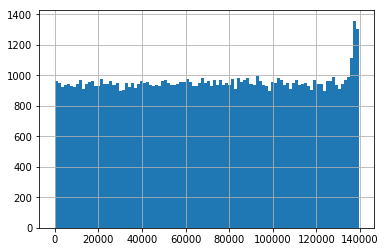

In [47]:
df_source['BatchId'].hist(bins = 100)

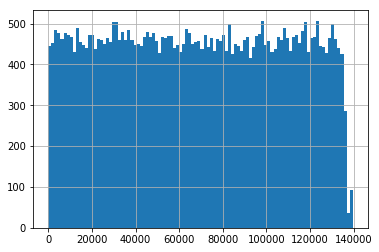

In [48]:
df_submission['BatchId'].hist(bins = 100)

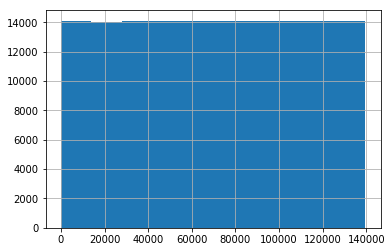

In [49]:
pd.concat((df_source, df_submission))['BatchId'].hist()

In [50]:
# Someone put more latest transactions inside the train

In [51]:
# Now I know the principle of splitting on train and test

In [52]:
for col in df_source.columns[:-1]:
    col, np.intersect1d(df_source[col], df_submission[col]).shape

('CustomerId', (1281,))

('AccountId', (1263,))

('SubscriptionId', (1261,))

('BatchId', (0,))

('ChannelId', (4,))

('FraudResult', (0,))

('Fraud_Sure', (0,))

('PricingStrategy', (4,))

('ProductCategory', (8,))

('ProductId', (22,))

('ProviderId', (6,))

('SampleType', (0,))

('TransactionId', (0,))

('TransactionStartTime', (0,))

('Value', (581,))

In [53]:
df_fraud['AccountId'].unique()
df_fraud['AccountId'].unique().shape

array([3832, 2366, 3692, 1959, 4003, 3943, 4590, 1488, 1823, 4421,  777,
       4637, 1873,  368, 1754, 1825,  476, 3041, 4655, 3686, 2123, 3337,
       1520, 1898, 3636, 1317, 2289, 3519, 2461,  953, 1605, 4249, 4465,
       2043,  523, 1291, 1208, 1335, 1480,  530, 4841, 1609, 2244,  830,
        572, 1240, 2656, 4004, 1178,  352, 4687, 1909])

(52,)

In [54]:
df_fraud

,CustomerId,AccountId,SubscriptionId,BatchId,ChannelId,FraudResult,Fraud_Sure,PricingStrategy,ProductCategory,ProductId,ProviderId,SampleType,TransactionId,TransactionStartTime,Value,Amount
131,4275,3832,4161,93685,3,1,1,0,financial_services,15,3,Train,60873,2018-11-15 08:04:51,700000,700000.0
146,7414,2366,4834,125553,1,1,1,2,financial_services,9,5,Train,28016,2018-11-15 08:20:09,725000,725000.0
155,4275,3832,4161,10381,3,1,1,0,financial_services,15,3,Train,1149,2018-11-15 08:31:57,700000,700000.0
2376,4134,3692,3451,52644,3,1,1,0,financial_services,15,1,Train,136904,2018-11-17 09:15:23,700000,700000.0
2452,4275,3832,4161,54481,3,1,1,0,financial_services,15,3,Train,88818,2018-11-17 11:49:46,700000,700000.0
3778,7414,2366,4834,34263,1,1,1,2,financial_services,9,5,Train,65985,2018-11-19 12:10:31,905000,905000.0
4500,2353,1959,1476,127498,3,1,1,0,financial_services,15,3,Train,4222,2018-11-20 12:00:29,800000,800000.0
4508,4453,4003,3002,79762,3,1,1,0,financial_services,15,5,Train,2550,2018-11-20 12:27:15,770000,770000.0
4755,4391,3943,1417,77828,3,1,1,0,financial_services,15,5,Train,49480,2018-11-20 22:11:53,500000,500000.0
4911,5054,4590,666,89498,3,1,1,4,airtime,3,5,Train,66468,2018-11-21 08:26:49,500000,500000.0


Just looking at Fraud Objects one may see some patterns like:

- Almost all fraud transactions have large 'Value' feature
- There are lots of repeated amounts like 500k, 1kk, 2kk and etc.

In [55]:
df_fraud['Value'].value_counts()

500000     49
5000000    13
2000000     9
100000      9
3000000     9
800000      8
700000      6
540000      6
900000      6
200000      4
1000000     4
2450000     4
750000      4
599137      4
521000      4
600000      3
2960000     2
599100      2
50000       2
2950000     2
530000      2
1160000     2
4000000     1
860000      1
9880000     1
880000      1
30000       1
520000      1
905000      1
300000      1
1850000     1
400000      1
1660000     1
9860888     1
720000      1
650000      1
790000      1
450000      1
725000      1
1005        1
1170000     1
733000      1
770000      1
9850000     1
9870000     1
9856000     1
1900000     1
550000      1
629374      1
588668      1
1115000     1
500         1
680000      1
508000      1
9800000     1
1509988     1
2800000     1
2500000     1
7000000     1
1500000     1
8600000     1
Name: Value, dtype: int64

In [56]:
# df_source.query("Value < 500_000") # All are 1 except 1
# df_source.query("Value == 500_000") # All are 1 except 1
# df_source.query("Value == 500_000 and FraudResult == 0") # Why?
# df_source.query("Value > 500_000 and Value < 900_000") # All are 1
# df_source.query("Value > 2_000_000") # All are 1 except 1

### Number of Fraud Transactions

In [57]:
# pd.read_csv('submissions/submission_rules_all_1.csv')['FraudResult'].sum()
df_submission.shape[0]

45019

In [58]:
# submitting all 1
Recall = 1

In [59]:
# F / (2-F)*(df_submission.shape[0] * 0.5) * 45019 ~ 50

Thus, there are 25 frauds in the public data and *approximately* 50 in the whole dataset

Now it's possible to figure out *probable* number of TP in each submission

In [60]:
F = 0.690909090909091 # N_pos = 30
# F = 0.64 # N_pos = 25, removed 8 of 1
# F = 0.615384615384615 # N_pos = 27
# F = 0.692307692307692 # After adding 1 in 3.3.4 N_pos 28, TP 19
# F = 0.727272727272727 # N_pos 30, TP = 20
# F = 0.64 # N_pos 25, TP = 16
# F = 0.679245283018868 # 5 frauds in 2кк. N_pos 28, TP = 18
# F = 0.666666666666667 # N_pos 28, TP = 18||| | 26 / 17
# F = 0.740740740740741 # N_pos 29 TP 20
# F = 0.529411764705882 # N_pos 9 TP 9
# F = 0.555555555555556 # N_pos 11 TP 10
# F = 0.571428571428572 # N_pos 10 TP 10
# F = 0.571428571428572 # N_pos 10 TP 10
# F = 0.595744680851064 # N_pos 22 TP 14
# F = 0.526315789473684 # N_pos 13 TP 10
# F = 0.536585365853659 # N_pos 16 TP 11
# F = 0.540540540540541 # N_pos 12 TP 10
# F = 0.526315789473684 # N_pos 13 TP 10
# F = 0.611111111111111 # N_pos 11 TP 11
# F = 0.684210526315789 # N_pos 13 TP 13
# F = 0.717948717948718 # N_pos 14 TP 14
# F = 0.897959183673469 # N_pos 24 TP 22
# F = 0.837209302325581 # N_pos 18 TP 18
# F = 0.893617021276596 # N_pos 22 TP 21
# F = 0.717948717948718
# F = 0.96
# F = 0.979591836734694
# F = 0.943396226415094
# F = 0.0769230769230769

N_pos = df_submission['FraudResult'].sum()
"N_pos", N_pos

N_pos_ALL = 25

# The whole dataset. FINAL SCORE
# F = 0.894736842105263
# N_pos_ALL = 51

TP_public_list = []
for N_pos in range(1,51):
    TP_public = F*(N_pos_ALL + N_pos) / 2
    P = TP_public / N_pos
    R = TP_public / N_pos_ALL
    F_assumed = 2*P*R / (P + R)
    TP_public_list.append({'N_pos_ALL':N_pos_ALL,
                           'N_pos':N_pos,
                           'TP_public':TP_public,
                           'Precision_assumed':P,
                           'Recall_assumed':R,
                           'F_assumed':F_assumed,
                          })
df_TP_public_list = pd.DataFrame(TP_public_list)
df_TP_public_list['TP_public_round'] = df_TP_public_list['TP_public'].round()
args_sorted = (df_TP_public_list['TP_public'] - df_TP_public_list['TP_public_round']).abs().argsort()
df_TP_public_list.loc[args_sorted]

('N_pos', 0.0)

,F_assumed,N_pos,N_pos_ALL,Precision_assumed,Recall_assumed,TP_public,TP_public_round
29,0.690909,30,25,0.633333,0.760000,19.000000,19.0
0,0.690909,1,25,8.981818,0.359273,8.981818,9.0
3,0.690909,4,25,2.504545,0.400727,10.018182,10.0
26,0.690909,27,25,0.665320,0.718545,17.963636,18.0
32,0.690909,33,25,0.607163,0.801455,20.036364,20.0
6,0.690909,7,25,1.579221,0.442182,11.054545,11.0
23,0.690909,24,25,0.705303,0.677091,16.927273,17.0
35,0.690909,36,25,0.585354,0.842909,21.072727,21.0
49,0.690909,50,25,0.518182,1.036364,25.909091,26.0
9,0.690909,10,25,1.209091,0.483636,12.090909,12.0


### Rules

In [61]:
# df_submission_copy = df_submission.copy()
# df_submission = df_submission_copy.copy()

In [62]:
# df_submission.columns

In [63]:
# df_submission.drop('Fraud_sure', axis=1, inplace=True)

In [64]:
df_submission['Fraud_Sure'] = 0
df_submission['FraudResult'] = np.nan

In [65]:
df_submission.shape

(45019, 16)

#### > 2000_000

In [66]:
df_submission.query("Value > 2000000")
df_submission.query("Value > 2000000").shape

,CustomerId,AccountId,SubscriptionId,BatchId,ChannelId,FraudResult,Fraud_Sure,PricingStrategy,ProductCategory,ProductId,ProviderId,SampleType,TransactionId,TransactionStartTime,Value,Amount
2728,3938,3501,3741,2518,3,NaN,0,2,financial_services,15,1,Test,50612,2019-02-14 16:21:04,9000000,9000000.0
13050,634,306,1121,129429,3,NaN,0,2,financial_services,15,3,Test,58126,2019-02-21 13:30:59,3000000,3000000.0
13051,634,306,1121,129429,3,NaN,0,2,financial_services,15,3,Test,96723,2019-02-21 13:31:15,3000000,3000000.0
15546,5193,4725,3244,17376,3,NaN,0,4,airtime,10,5,Test,120345,2019-02-22 13:35:52,9500000,9500000.0
21752,3772,3341,1891,20535,3,NaN,0,2,financial_services,15,5,Test,41874,2019-02-27 08:34:30,5000000,5000000.0
21888,3239,2817,4785,74361,3,NaN,0,2,financial_services,15,5,Test,20171,2019-02-27 11:24:46,3000000,3000000.0
30847,3330,629,3857,51215,5,NaN,0,2,retail,26,4,Test,47953,2019-03-05 09:47:01,2500000,-2500000.0
43262,4827,4370,4537,96992,3,NaN,0,0,financial_services,15,5,Test,35117,2019-03-13 14:28:16,7871273,7871273.0


(8, 16)

In [67]:
# df_source.query("CustomerId == 3330") #  (retail, OUTLIER)
# df_source.query("CustomerId == 4725") #  (airtime, OUTLIER)

In [68]:
# df_source.query("Value > 500000 and ProductCategory == 'airtime'")
# df_submission.query("Value > 500000 and ProductCategory == 'airtime'")

In [69]:
# row = df_submission.query("Value > 2000000").iloc[]
# find_number_unique_CAS_id(df_source, row['CustomerId'], row['AccountId'], row['SubscriptionId'])

# get_all_transactions_given_CAS(pd.concat((df_source, df_submission)),
#                                row['CustomerId'], row['AccountId'], row['SubscriptionId'])

In [70]:
# df_submission.loc[df_submission.query("Value > 2000000").index, 'FraudResult'] = 1
# df_submission.loc[[15546, 30847], 'FraudResult'] = 1 # One is in leaderboard, one is not. One may be 0
# df_submission.query("Value > 2000000") 

In [71]:
# df_submission.loc[df_submission.query("Value > 2000000").index, 'FraudResult'] = 0
# df_submission.loc[[15546, 21752, 21888, 30847, 43262], 'FraudResult'] = 1 # 

In [72]:
# df_submission.loc[[15546, 21752, 21888], 'FraudResult'] = 1 
# df_submission.loc[[30847, 43262], 'FraudResult'] = 0 

In [73]:
# df_submission.loc[df_submission.query("Value > 2000000").index, 'FraudResult'] = 1

In [74]:
# df_submission.loc[[30847], 'FraudResult'] = 0 

In [75]:
# df_submission.loc[30847, 'Fraud_Sure'] = 1

In [76]:
# df_submission.query("Value > 2000000")

In [77]:
# folder_submission_by_object = './submissions/by_object/ > 2_000_000/'
# folder_submission_notes_by_object = './submission-notes/by_object/ > 2_000_000/'

# if not os.path.exists(folder_submission_by_object): os.mkdir(folder_submission_by_object)
# if not os.path.exists(folder_submission_notes_by_object): os.mkdir(folder_submission_notes_by_object)
# for i in df_submission.query("Value > 2000000").index:
#     df_submission.loc[df_submission.query("Value > 2000000").index, 'FraudResult'] = 0
#     df_submission.loc[i, 'FraudResult'] = 1
    
#     submission_name = 'submission_rules_hand_probs_' + str(i)
#     note = """
#     df_submission.loc[i, 'FraudResult'] = 1
#     where i = """ + str(i)
#     make_submission(y_subm_pred=df_submission['FraudResult'].fillna(0).values,
#                     sample_subm_path='submissions/sample_submission.csv',
#                     csv_filepath=folder_submission_by_object + submission_name + '.csv',
#                     note_file_path=folder_submission_notes_by_object + submission_name,
#                     note=note
#                    )

In [78]:
def calc_sure_gr_2kk():
    df_submission.loc[2728, 'FraudResult'] = 1 # Sure
    df_submission.loc[13051, 'FraudResult'] = 1 # Sure
    df_submission.loc[15546, 'FraudResult'] = 1 # Sure
    df_submission.loc[30847, 'FraudResult'] = 0 # Sure
    df_submission.loc[43262, 'FraudResult'] = 1 # Sure

    df_submission.loc[2728, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[13051, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[15546, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[30847, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[43262, 'Fraud_Sure'] = 1 # Sure

#### >= 500000 and < 1000000

In [79]:
df_submission.query("Value >= 500000 and Value < 1000000").head()
df_submission.query("Value >= 500000 and Value < 1000000").shape

,CustomerId,AccountId,SubscriptionId,BatchId,ChannelId,FraudResult,Fraud_Sure,PricingStrategy,ProductCategory,ProductId,ProviderId,SampleType,TransactionId,TransactionStartTime,Value,Amount
324,4464,4014,4460,59201,3,NaN,0,2,financial_services,15,5,Test,59114,2019-02-13 16:16:18,800000,800000.0
325,4464,4014,4460,119744,3,NaN,0,2,financial_services,15,5,Test,36185,2019-02-13 16:17:16,500000,500000.0
328,4464,4014,4460,91920,3,NaN,0,2,financial_services,15,5,Test,18001,2019-02-13 16:18:39,500000,500000.0
330,4464,4014,4460,107261,3,NaN,0,2,financial_services,15,5,Test,38835,2019-02-13 16:20:36,500000,500000.0
460,4464,4014,4460,126134,3,NaN,0,2,financial_services,15,5,Test,116948,2019-02-13 18:22:42,530000,530000.0


(46, 16)

In [80]:
# df_submission.loc[df_submission.query("Value >= 500000 and Value < 1000000").index, 'FraudResult'] = 1

In [81]:
# 9 of 0, 11 of 1.

In [82]:
# df_submission.loc[df_submission.query("Value >= 500000 and Value < 1000000").index, 'FraudResult'] = 0

In [83]:
def calc_sure_500_1kk():
    df_submission.loc[324, 'FraudResult'] = 1 # Sure
    df_submission.loc[328, 'FraudResult'] = 1 # Sure
    df_submission.loc[462, 'FraudResult'] = 1 # Sure
    df_submission.loc[1373, 'FraudResult'] = 1 # Sure
    df_submission.loc[3114, 'FraudResult'] = 1 # Sure
    df_submission.loc[6731, 'FraudResult'] = 1 # Sure
    df_submission.loc[6838, 'FraudResult'] = 1 # Sure
    df_submission.loc[6892, 'FraudResult'] = 1 # Sure
    df_submission.loc[19782, 'FraudResult'] = 0 # Sure
    df_submission.loc[20849, 'FraudResult'] = 0 # Sure
    df_submission.loc[21691, 'FraudResult'] = 0 # Sure
    df_submission.loc[22068, 'FraudResult'] = 0 # Sure
    df_submission.loc[24868, 'FraudResult'] = 0 # Sure
    df_submission.loc[24939, 'FraudResult'] = 0 # Sure
    df_submission.loc[27742, 'FraudResult'] = 0 # Sure
    df_submission.loc[38518, 'FraudResult'] = 0 # Sure
    df_submission.loc[38618, 'FraudResult'] = 0 # Sure
    df_submission.loc[40379, 'FraudResult'] = 1 # Sure
    df_submission.loc[43896, 'FraudResult'] = 1 # Sure
    df_submission.loc[44033, 'FraudResult'] = 1 # Sure

    df_submission.loc[324, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[328, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[462, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[1373, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[3114, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[6731, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[6838, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[6892, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[19782, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[20849, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[21691, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[22068, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[24868, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[24939, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[27742, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[38518, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[38618, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[40379, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[43896, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[44033, 'Fraud_Sure'] = 1 # Sure

In [84]:
# sure_indexes_500 = [324, 328, 462, 1373, 3114, 6731, 6838, 6892, 19782, 20849, 21691, 22068, 24868, 
#                     24939, 27742, 38518, 38618,]
# idx = sure_indexes_500[16]
# row = df_submission.loc[idx]
# get_all_transactions_given_CAS(pd.concat((df_source, df_submission)),
#                                row['CustomerId'], row['AccountId'], row['SubscriptionId'])

#### 2000000

In [85]:
get_source_with_CPPP(df_source, 3,2,15,3).query("Value == 2000000")

,CustomerId,AccountId,SubscriptionId,BatchId,ChannelId,FraudResult,Fraud_Sure,PricingStrategy,ProductCategory,ProductId,ProviderId,SampleType,TransactionId,TransactionStartTime,Value,Amount
13142,1858,1488,814,121053,3,1,1,2,financial_services,15,3,Train,66303,2018-12-01 20:29:47,2000000,2000000.0
55349,2877,2461,2416,58233,3,0,1,2,financial_services,15,3,Train,38705,2019-01-09 15:12:24,2000000,2000000.0
64357,1302,953,162,118851,3,1,1,2,financial_services,15,3,Train,85815,2019-01-18 15:09:59,2000000,2000000.0
76785,1602,1240,4672,133354,3,0,1,2,financial_services,15,3,Train,93915,2019-01-28 21:09:43,2000000,2000000.0
76786,1602,1240,4672,133354,3,1,1,2,financial_services,15,3,Train,49913,2019-01-28 21:10:27,2000000,2000000.0
94804,5155,4687,4160,105975,3,0,1,2,financial_services,15,3,Train,64911,2019-02-12 13:59:08,2000000,2000000.0
94805,5155,4687,4160,111976,3,1,1,2,financial_services,15,3,Train,69673,2019-02-12 14:00:41,2000000,2000000.0


In [86]:
df_submission.query("Value == 2000000")

,CustomerId,AccountId,SubscriptionId,BatchId,ChannelId,FraudResult,Fraud_Sure,PricingStrategy,ProductCategory,ProductId,ProviderId,SampleType,TransactionId,TransactionStartTime,Value,Amount
5256,514,191,897,87067,3,NaN,0,2,financial_services,15,3,Test,11374,2019-02-15 14:40:43,2000000,2000000.0
5271,514,191,897,1770,3,NaN,0,2,financial_services,15,3,Test,88480,2019-02-15 14:50:04,2000000,2000000.0
5273,514,191,897,1770,3,NaN,0,2,financial_services,15,3,Test,54314,2019-02-15 14:53:55,2000000,2000000.0
5276,514,191,897,84992,3,NaN,0,2,financial_services,15,3,Test,24572,2019-02-15 14:55:04,2000000,2000000.0
5367,514,191,897,78133,3,NaN,0,2,financial_services,15,3,Test,62319,2019-02-15 15:32:58,2000000,2000000.0
11023,4240,3797,4301,50225,3,NaN,0,2,financial_services,15,3,Test,6746,2019-02-19 20:44:47,2000000,2000000.0
17626,634,306,1121,90783,3,NaN,0,2,financial_services,15,3,Test,66741,2019-02-23 12:57:39,2000000,2000000.0
17627,634,306,1121,90783,3,NaN,0,2,financial_services,15,3,Test,56324,2019-02-23 12:58:11,2000000,2000000.0
19763,4522,4072,2518,42159,3,NaN,0,2,financial_services,15,3,Test,11832,2019-02-25 13:27:28,2000000,2000000.0
19897,1644,1282,3295,59974,3,NaN,0,2,financial_services,15,3,Test,22203,2019-02-25 14:49:18,2000000,2000000.0


In [87]:
# row = df_submission.query("Value == 2000000").iloc[1]
# find_number_unique_CAS_id(df_source, row['CustomerId'], row['AccountId'], row['SubscriptionId'])

# get_all_transactions_given_CAS(pd.concat((df_source, df_submission)),
#                                row['CustomerId'], row['AccountId'], row['SubscriptionId'])

In [88]:
# for CustId in df_submission.query("Value == 2000000")['CustomerId'].unique():
#     CustId
#     df_source.query(f"CustomerId == {CustId}")

In [89]:
# df_submission.query("CustomerId == 514") # ? Time between transactions
# df_submission.query("CustomerId == 4240") # First fraud - 500_000 means this is 1 too
# 4240 Есть транзакции в df_source
# df_submission.query("CustomerId == 634") # 1st OK, 2nd NOT
# df_submission.query("CustomerId == 4522") # FIRST TRANSACTION
# df_submission.query("CustomerId == 1644") # FIRST TRANSACTION

In [90]:
# df_submission.loc[5256, 'FraudResult'] = 1 # Sure
# df_submission.loc[[5271, 5273, 5276, 5367], 'FraudResult'] = 1 # 
# df_submission.loc[11023, 'FraudResult'] = 1 # Not Sure
# df_submission.loc[17626, 'FraudResult'] = 1 # Need Model
# df_submission.loc[17627, 'FraudResult'] = 1 # 
# df_submission.loc[19763, 'FraudResult'] = 0 # Sure
# df_submission.loc[19897, 'FraudResult'] = 0 # Sure

# # p = get_source_with_CPPP(df_source, 3,2,15,1).query("Value == 2000000")['FraudResult'].mean()
# df_submission.loc[20146, 'FraudResult'] = 0 # Sure

In [91]:
# row = df_submission.query("Value == 2000000").loc[11023]
# # row = df_submission.query("Value == 2000000").loc[17626]
# # row = df_submission.query("Value == 2000000").loc[20146]
# get_all_transactions_given_CAS(pd.concat((df_source, df_submission)),
#                           row['CustomerId'], row['AccountId'], row['SubscriptionId'])

In [92]:
# df_source.query("CustomerId == 5155")
# df_source.query("AccountId == 4421")
# df_source.query("SubscriptionId == 4038")

In [93]:
# folder_submission_by_object = './submissions/by_object/2_000_000/'
# folder_submission_notes_by_object = './submission-notes/by_object/2_000_000/'

# if not os.path.exists(folder_submission_by_object): os.mkdir(folder_submission_by_object)
# if not os.path.exists(folder_submission_notes_by_object): os.mkdir(folder_submission_notes_by_object)
# for i in df_submission.query("Value == 2000000").index:
#     df_submission.loc[df_submission.query("Value == 2000000").index, 'FraudResult'] = 0
#     df_submission.loc[i, 'FraudResult'] = 1
    
#     submission_name = str(i) + '_submission_rules_hand_probs'
#     note = """
#     df_submission.loc[i, 'FraudResult'] = 1
#     where i = """ + str(i)
#     make_submission(y_subm_pred=df_submission['FraudResult'].fillna(0).values,
#                     sample_subm_path='submissions/sample_submission.csv',
#                     csv_filepath=folder_submission_by_object + submission_name + '.csv',
#                     note_file_path=folder_submission_notes_by_object + submission_name,
#                     note=note
#                    )

In [94]:
def calc_sure_2kk():
    df_submission.loc[5256, 'FraudResult'] = 1 # Sure
    df_submission.loc[5367, 'FraudResult'] = 1 # Sure
    df_submission.loc[17626, 'FraudResult'] = 1 # Sure
    df_submission.loc[19763, 'FraudResult'] = 0 # Sure
    df_submission.loc[19897, 'FraudResult'] = 0 # Sure
    df_submission.loc[20146, 'FraudResult'] = 0 # Sure

    df_submission.loc[5256, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[5367, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[17626, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[19763, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[19897, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[20146, 'Fraud_Sure'] = 1 # Sure

#### > 1000000 and < 2000000

In [95]:
df_submission.query("Value > 1000000 and Value < 2000000")
df_submission.query("Value > 1000000 and Value < 2000000").shape

,CustomerId,AccountId,SubscriptionId,BatchId,ChannelId,FraudResult,Fraud_Sure,PricingStrategy,ProductCategory,ProductId,ProviderId,SampleType,TransactionId,TransactionStartTime,Value,Amount
5233,4464,4014,4460,46075,3,NaN,0,2,financial_services,15,5,Test,59334,2019-02-15 14:30:30,1200000,1200000.0
5237,4464,4014,4460,6938,3,NaN,0,2,financial_services,15,5,Test,107721,2019-02-15 14:32:39,1200000,1200000.0
5246,4464,4014,4460,84488,3,NaN,0,2,financial_services,15,5,Test,22658,2019-02-15 14:35:29,1200000,1200000.0
5257,4464,4014,4460,48089,3,NaN,0,2,financial_services,15,5,Test,39833,2019-02-15 14:41:51,1200000,1200000.0
17631,634,306,1121,118852,3,NaN,0,2,financial_services,15,3,Test,52013,2019-02-23 13:00:19,1500000,1500000.0
17632,634,306,1121,118852,3,NaN,0,2,financial_services,15,3,Test,25972,2019-02-23 13:00:35,1500000,1500000.0
22076,3661,3233,3710,53070,3,NaN,0,2,financial_services,15,5,Test,45907,2019-02-27 14:57:45,1200000,1200000.0
30852,2795,629,3857,65073,5,NaN,0,2,retail,26,4,Test,76482,2019-03-05 09:48:51,1200000,-1200000.0


(8, 16)

In [96]:
# row = df_submission.query("Value > 1000000 and Value < 2000000").iloc[0]
# find_number_unique_CAS_id(df_source, row['CustomerId'], row['AccountId'], row['SubscriptionId'])

# get_all_transactions_given_CAS(pd.concat((df_source, df_submission)),
#                                row['CustomerId'], row['AccountId'], row['SubscriptionId'])

In [97]:
# df_submission.loc[[5233, 5237, 5246, 5257, 17631, 17632], 'FraudResult'] = 1
# df_submission.loc[[5233, 17631, 17632], 'FraudResult'] = 1 # 2 of 3 exist

# df_submission.loc[22076, 'FraudResult'] = 0 # Sure
# df_submission.loc[30852, 'FraudResult'] = 0 # Sure

In [98]:
# df_submission.shape
# df_submission['BatchId'].unique().shape
# non_unique_batches = df_submission['BatchId'].value_counts()[df_submission['BatchId'].value_counts() > 1].index
# df_submission[df_submission['BatchId'].isin(non_unique_batches)].query("Value < 500000 and Value >= 100000")

In [99]:
# df_source.query("CustomerId == 5155")

In [100]:
# folder_submission_by_object = './submissions/by_object/> 1kk < x < 2kk/'
# folder_submission_notes_by_object = './submission-notes/by_object/> 1kk < x < 2kk/'

# if not os.path.exists(folder_submission_by_object): os.mkdir(folder_submission_by_object)
# if not os.path.exists(folder_submission_notes_by_object): os.mkdir(folder_submission_notes_by_object)
# for i in df_submission.query("Value > 1000000 and Value < 2000000").index:
#     df_submission.loc[df_submission.query("Value > 1000000 and Value < 2000000").index, 'FraudResult'] = 0
#     df_submission.loc[i, 'FraudResult'] = 1
    
#     submission_name = str(i) + '_submission_rules_hand_probs'
#     note = """
#     df_submission.loc[i, 'FraudResult'] = 1
#     where i = """ + str(i)
#     make_submission(y_subm_pred=df_submission['FraudResult'].fillna(0).values,
#                     sample_subm_path='submissions/sample_submission.csv',
#                     csv_filepath=folder_submission_by_object + submission_name + '.csv',
#                     note_file_path=folder_submission_notes_by_object + submission_name,
#                     note=note
#                    )

In [101]:
def calc_sure_1kk_2kk():
    df_submission.loc[5233, 'FraudResult'] = 1 # Sure
    df_submission.loc[5257, 'FraudResult'] = 1 # Sure
    df_submission.loc[17632, 'FraudResult'] = 1 # Sure
    df_submission.loc[22076, 'FraudResult'] = 0 # Sure
    df_submission.loc[30852, 'FraudResult'] = 0 # Sure

    df_submission.loc[5233, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[5257, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[17632, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[22076, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[30852, 'Fraud_Sure'] = 1 # Sure

#### 1000_000

In [102]:
df_submission.query("Value == 1000_000")
df_submission.query("Value == 1000_000").shape

,CustomerId,AccountId,SubscriptionId,BatchId,ChannelId,FraudResult,Fraud_Sure,PricingStrategy,ProductCategory,ProductId,ProviderId,SampleType,TransactionId,TransactionStartTime,Value,Amount
5258,4464,4014,4460,68641,3,NaN,0,2,financial_services,15,5,Test,103156,2019-02-15 14:42:56,1000000,1000000.0
5268,4464,4014,4460,71666,3,NaN,0,2,financial_services,15,5,Test,59289,2019-02-15 14:46:07,1000000,1000000.0
6904,4240,3797,4301,123218,3,NaN,0,2,financial_services,15,3,Test,6285,2019-02-16 09:28:12,1000000,1000000.0
12839,634,306,1121,25123,3,NaN,0,2,financial_services,15,3,Test,10183,2019-02-21 09:53:55,1000000,1000000.0
12840,634,306,1121,25123,3,NaN,0,2,financial_services,15,3,Test,53904,2019-02-21 09:54:25,1000000,1000000.0
12842,634,306,1121,25123,3,NaN,0,2,financial_services,15,3,Test,112983,2019-02-21 09:54:42,1000000,1000000.0
12843,634,306,1121,25123,3,NaN,0,2,financial_services,15,3,Test,132243,2019-02-21 09:54:54,1000000,1000000.0
13411,2563,2158,1811,62441,3,NaN,0,2,financial_services,15,1,Test,66029,2019-02-21 19:01:38,1000000,1000000.0
17633,634,306,1121,79139,3,NaN,0,2,financial_services,15,3,Test,87268,2019-02-23 13:01:54,1000000,1000000.0
17634,634,306,1121,79139,3,NaN,0,2,financial_services,15,3,Test,59595,2019-02-23 13:02:04,1000000,1000000.0


(21, 16)

In [103]:
# row = df_submission.query("Value == 1000_000").iloc[-6]
# find_number_unique_CAS_id(df_source, row['CustomerId'], row['AccountId'], row['SubscriptionId'])

# get_all_transactions_given_CAS(pd.concat((df_source, df_submission)),
#                                row['CustomerId'], row['AccountId'], row['SubscriptionId'])

In [104]:
# df_submission.loc[df_submission.query("Value == 1000_000").index, 'FraudResult'] = 1
# 4 of 11 them are 1. Others - 0

In [105]:
# df_submission.loc[df_submission.query("Value == 1000_000").index, 'FraudResult'] = 0

In [106]:
# df_submission.loc[[12839, 12840, 12842, 12843], 'FraudResult'] = 1 # or
# df_submission.loc[[12839, 12840, 12842, 12843], 'FraudResult'] = 0 # or

In [107]:
# index_list = [19674, 19677, 19969, 19971, 20489, 22205, 23053, 27739, 27741]
#              [19674, 1,       нет,   нет, 20489, 22205, 23053, 27739, 27741]
# df_submission.loc[index_list, 'FraudResult'] = 1 # 

In [108]:
# index_list = [27739, 27741]
# len(index_list)
# df_submission.loc[index_list, 'FraudResult'] = 0 # Sure

In [109]:
# index_list = [20489, 22205, 23053]
# len(index_list)
# df_submission.loc[index_list, 'FraudResult'] = 0 # Sure

In [110]:
# index_list = [19674, 19677, 19969, 19971] # 
# len(index_list)
# df_submission.loc[index_list, 'FraudResult'] = 1 # Sure

In [111]:
# index_list = [17633, 17634, 19271, 19273]
# len(index_list)
# df_submission.loc[index_list, 'FraudResult'] = 1 # 2 Both are 1. Sure

In [112]:
# index_list = [ 5258,  5268,  6904, 13411]
# len(index_list)
# df_submission.loc[index_list, 'FraudResult'] = 1 # 1 is Fraud

In [113]:
# NOT_SURE = [12840, 12843, 17633, 19674]

In [114]:
# folder_submission_by_object = './submissions/by_object/1000_000/'
# folder_submission_notes_by_object = './submission-notes/by_object/1000_000/'

# if not os.path.exists(folder_submission_by_object): os.mkdir(folder_submission_by_object)
# if not os.path.exists(folder_submission_notes_by_object): os.mkdir(folder_submission_notes_by_object)
# for i in df_submission.query("Value == 1000000").index:
#     df_submission.loc[df_submission.query("Value == 1000000").index, 'FraudResult'] = 0
#     df_submission.loc[i, 'FraudResult'] = 1
    
#     submission_name = str(i) + '_submission_rules_hand_probs'
#     note = """
#     df_submission.loc[i, 'FraudResult'] = 1
#     where i = """ + str(i)
#     make_submission(y_subm_pred=df_submission['FraudResult'].fillna(0).values,
#                     sample_subm_path='submissions/sample_submission.csv',
#                     csv_filepath=folder_submission_by_object + submission_name + '.csv',
#                     note_file_path=folder_submission_notes_by_object + submission_name,
#                     note=note
#                    )

In [115]:
def calc_sure_1kk():
    df_submission.loc[5258, 'FraudResult'] = 1 # Sure
    df_submission.loc[12839, 'FraudResult'] = 0 # Sure
    df_submission.loc[12840, 'FraudResult'] = 0 # Sure
    df_submission.loc[12842, 'FraudResult'] = 0 # Sure
    df_submission.loc[12843, 'FraudResult'] = 0 # Sure
    
    df_submission.loc[17633, 'FraudResult'] = 1 # Sure
    df_submission.loc[17634, 'FraudResult'] = 1 # Sure
    df_submission.loc[19677, 'FraudResult'] = 1 # Sure
    df_submission.loc[20489, 'FraudResult'] = 0 # Sure
    df_submission.loc[22205, 'FraudResult'] = 0 # Sure
    df_submission.loc[23053, 'FraudResult'] = 0 # Sure
    df_submission.loc[27739, 'FraudResult'] = 0 # Sure
    df_submission.loc[27741, 'FraudResult'] = 0 # Sure

    df_submission.loc[5258, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[12839, 'Fraud_Sure'] = 1 # Sure 
    df_submission.loc[12840, 'Fraud_Sure'] = 1 # Sure 
    df_submission.loc[12842, 'Fraud_Sure'] = 1 # Sure 
    df_submission.loc[12843, 'Fraud_Sure'] = 1 # Sure 
    df_submission.loc[17633, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[17634, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[19677, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[20489, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[22205, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[23053, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[27739, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[27741, 'Fraud_Sure'] = 1 # Sure

#### less 500_000

In [116]:
# which_indexes_to_check = [2328,  2341,  2351,  11305, 21947, 21954, 21963]
# which_indexes_to_check = df_submission.query("Value >= 400_000 and Value < 500_000").index

In [117]:
def calc_less_500k():
    df_submission.loc[2328, 'FraudResult'] = 0 # Sure
    df_submission.loc[2341, 'FraudResult'] = 0 # Sure
    df_submission.loc[2351, 'FraudResult'] = 0 # Sure
    df_submission.loc[3980, 'FraudResult'] = 0 # Sure
    df_submission.loc[20133, 'FraudResult'] = 0 # Sure
    df_submission.loc[20135,  'FraudResult'] = 0 # Sure
    df_submission.loc[20890, 'FraudResult'] = 0 # Sure
    df_submission.loc[22553, 'FraudResult'] = 0 # Sure
    df_submission.loc[26886, 'FraudResult'] = 0 # Sure
    df_submission.loc[30850, 'FraudResult'] = 0 # Sure
    df_submission.loc[43662, 'FraudResult'] = 0 # Sure
    
    df_submission.loc[2328, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[2341, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[2351, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[3980, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[20133, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[20135, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[20890, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[22553, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[26886, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[30850, 'Fraud_Sure'] = 1 # Sure
    df_submission.loc[43662, 'Fraud_Sure'] = 1 # Sure

In [118]:
# folder_submission_by_object = './submissions/by_object/< 500_000/'
# folder_submission_notes_by_object = './submission-notes/by_object/< 500_000/'

# if not os.path.exists(folder_submission_by_object): os.mkdir(folder_submission_by_object)
# if not os.path.exists(folder_submission_notes_by_object): os.mkdir(folder_submission_notes_by_object)
# for i in which_indexes_to_check:
#     df_submission.loc[which_indexes_to_check, 'FraudResult'] = 0
#     df_submission.loc[i, 'FraudResult'] = 1
    
#     submission_name = str(i) + '_submission_rules_hand_probs'
#     note = """
#     df_submission.loc[i, 'FraudResult'] = 1
#     where i = """ + str(i)
#     make_submission(y_subm_pred=df_submission['FraudResult'].fillna(0).values,
#                     sample_subm_path='submissions/sample_submission.csv',
#                     csv_filepath=folder_submission_by_object + submission_name + '.csv',
#                     note_file_path=folder_submission_notes_by_object + submission_name,
#                     note=note
#                    )

In [119]:
df_submission['FraudResult'] = np.nan
df_submission['Fraud_Sure'] = 0

In [120]:
calc_less_500k()
calc_sure_1kk()
calc_sure_1kk_2kk()
calc_sure_2kk()
calc_sure_500_1kk()
calc_sure_gr_2kk()

In [121]:
df_submission['FraudResult'].sum()
df_submission['Fraud_Sure'].sum()

25.0

60

## Building Final Model

### Feature Engineering

In [122]:
df_source.columns
df_submission.columns

Index(['CustomerId', 'AccountId', 'SubscriptionId', 'BatchId', 'ChannelId',
       'FraudResult', 'Fraud_Sure', 'PricingStrategy', 'ProductCategory',
       'ProductId', 'ProviderId', 'SampleType', 'TransactionId',
       'TransactionStartTime', 'Value', 'Amount'],
      dtype='object')

Index(['CustomerId', 'AccountId', 'SubscriptionId', 'BatchId', 'ChannelId',
       'FraudResult', 'Fraud_Sure', 'PricingStrategy', 'ProductCategory',
       'ProductId', 'ProviderId', 'SampleType', 'TransactionId',
       'TransactionStartTime', 'Value', 'Amount'],
      dtype='object')

In [123]:
df_sample = pd.concat((df_source, df_submission))

In [124]:
df_sample.sort_values(['CustomerId', 'TransactionStartTime'], inplace=True)

In [125]:
# df_sample.to_csv('df_sample.csv')

In [126]:
# df_sample = pd.read_csv('df_sample.csv', index_col=0)

In [127]:
df_sample['TransactionStartTime_secs'] = df_sample['TransactionStartTime'].astype("<M8[s]").astype(int) / (10**9)

In [128]:
%%time
df_sample_shifted_1 = df_sample.shift(1)
df_sample_shifted_2 = df_sample.shift(2)
df_sample_shifted_3 = df_sample.shift(3)
df_sample_shifted_4 = df_sample.shift(4)
df_sample_shifted_next_1 = df_sample.shift(-1)
df_sample_shifted_next_2 = df_sample.shift(-2)
df_sample_shifted_next_3 = df_sample.shift(-3)
df_sample_shifted_next_4 = df_sample.shift(-4)

CPU times: user 679 ms, sys: 381 ms, total: 1.06 s
Wall time: 265 ms


In [129]:
%%time
delta_field_names = ['TransactionStartTime_secs', 'Value']
for field_name in delta_field_names:
    df_sample['delta_'+field_name+'_0_1'] = (df_sample[field_name] - df_sample_shifted_1[field_name])
    df_sample['delta_'+field_name+'_0_2'] = (df_sample[field_name] - df_sample_shifted_2[field_name])
    df_sample['delta_'+field_name+'_0_3'] = (df_sample[field_name] - df_sample_shifted_3[field_name])
    df_sample['delta_'+field_name+'_0_4'] = (df_sample[field_name] - df_sample_shifted_4[field_name])
    df_sample['delta_'+field_name+'_0_next_1'] = (df_sample[field_name] - df_sample_shifted_next_1[field_name])
    df_sample['delta_'+field_name+'_0_next_2'] = (df_sample[field_name] - df_sample_shifted_next_2[field_name])
    df_sample['delta_'+field_name+'_0_next_3'] = (df_sample[field_name] - df_sample_shifted_next_3[field_name])
    df_sample['delta_'+field_name+'_0_next_4'] = (df_sample[field_name] - df_sample_shifted_next_4[field_name])
    
    mask = df_sample['CustomerId'] != df_sample_shifted_1['CustomerId']
    df_sample['delta_'+field_name+'_0_1'][mask] = np.nan
    mask = df_sample['CustomerId'] != df_sample_shifted_2['CustomerId']
    df_sample['delta_'+field_name+'_0_2'][mask] = np.nan
    mask = df_sample['CustomerId'] != df_sample_shifted_3['CustomerId']
    df_sample['delta_'+field_name+'_0_3'][mask] = np.nan
    mask = df_sample['CustomerId'] != df_sample_shifted_4['CustomerId']
    df_sample['delta_'+field_name+'_0_4'][mask] = np.nan
    mask = df_sample['CustomerId'] != df_sample_shifted_next_1['CustomerId']
    df_sample['delta_'+field_name+'_0_next_1'][mask] = np.nan
    mask = df_sample['CustomerId'] != df_sample_shifted_next_2['CustomerId']
    df_sample['delta_'+field_name+'_0_next_2'][mask] = np.nan
    mask = df_sample['CustomerId'] != df_sample_shifted_next_3['CustomerId']
    df_sample['delta_'+field_name+'_0_next_3'][mask] = np.nan
    mask = df_sample['CustomerId'] != df_sample_shifted_next_4['CustomerId']
    df_sample['delta_'+field_name+'_0_next_4'][mask] = np.nan

/home/veegaaa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/veegaaa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/veegaaa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/veegaaa/anaconda3/lib/python3.6/site-packages/ipykernel_lau

CPU times: user 2.12 s, sys: 367 ms, total: 2.48 s
Wall time: 1.21 s


In [130]:
CustomerId_last_indexes = df_sample.reset_index().groupby('CustomerId')['index'].last()
df_sample['is_last_transaction'] = 0
df_sample.loc[CustomerId_last_indexes.values, 'is_last_transaction'] = 1

In [131]:
CustomerId_first_indexes = df_sample.reset_index().groupby('CustomerId')['index'].last()
df_sample['is_first_transaction'] = 0
df_sample.loc[CustomerId_first_indexes.values, 'is_first_transaction'] = 1

In [132]:
df_sample['N_trans_C'] = df_sample['CustomerId'].map(df_sample.groupby('CustomerId').size())
df_sample['N_trans_A'] = df_sample['AccountId'].map(df_sample.groupby('AccountId').size())
df_sample['N_trans_S'] = df_sample['SubscriptionId'].map(df_sample.groupby('SubscriptionId').size())
df_sample['N_trans_Batch'] = df_sample['BatchId'].map(df_sample.groupby('BatchId').size())

df_sample['C_mean_Value'] = df_sample['CustomerId'].map(df_sample.groupby('CustomerId')['Value'].mean())

In [133]:
df_sample['SampleType'].unique()

array(['Train', 'Test'], dtype=object)

In [134]:
df_train_test = df_sample.query("Fraud_Sure == 1")

In [135]:
df_train, df_test = model_selection.train_test_split(df_train_test, test_size=0.3, random_state=17)

In [136]:
df_submission_feat_eng = df_sample.query("SampleType == 'Test'")

In [137]:
y_train = df_train['FraudResult']
y_test = df_test['FraudResult']

In [138]:
feature_list = ['ChannelId',
                'PricingStrategy', 'ProductCategory',
       'ProductId', 'ProviderId', 
        'is_last_transaction', 'is_first_transaction',
                'Value', 'Amount', 
       'delta_TransactionStartTime_secs_0_1',
       'delta_TransactionStartTime_secs_0_2',
       'delta_TransactionStartTime_secs_0_3',
       'delta_TransactionStartTime_secs_0_4',
       'delta_TransactionStartTime_secs_0_next_1',
       'delta_TransactionStartTime_secs_0_next_2',
       'delta_TransactionStartTime_secs_0_next_3',
       'delta_TransactionStartTime_secs_0_next_4', 'delta_Value_0_1',
       'delta_Value_0_2', 'delta_Value_0_3', 'delta_Value_0_4',
       'delta_Value_0_next_1', 'delta_Value_0_next_2', 'delta_Value_0_next_3',
       'delta_Value_0_next_4', 
                'N_trans_C', 'N_trans_A', 'N_trans_S',
       'N_trans_Batch', 'C_mean_Value'
        ]

In [139]:
categ_feature_list = ['ChannelId', 'PricingStrategy', 'ProductCategory',
       'ProductId', 'ProviderId', 'is_last_transaction', 'is_first_transaction',
]

In [140]:
%%time
for col in categ_feature_list:
#     display(col)
    le = preprocessing.LabelEncoder()
    _ = le.fit(df_sample[col])
    df_train[col] = le.transform(df_train[col])
    df_test[col] = le.transform(df_test[col])
    df_submission_feat_eng[col] = le.transform(df_submission_feat_eng[col])

/home/veegaaa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/veegaaa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/veegaaa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

CPU times: user 1.24 s, sys: 7.12 ms, total: 1.24 s
Wall time: 1.24 s


In [141]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(
    n_estimators = 300,
    task =  'train',
    objective =  'binary',
    metric =  'logloss',
    learning_rate =  0.03,
#     feature_fraction =  0.80,
#     bagging_fraction =  0.80,
#     bagging_freq =  10,
    max_depth =  3,
    num_leaves =  8,
    min_data_in_leaf = 10,
    verbosity = -1,
    random_state = 17,
    n_jobs =  2,
)

In [142]:
lgb.fit(df_train[feature_list],y_train,
        eval_set = [(df_train[feature_list],y_train),(df_test[feature_list],y_test)],
        eval_metric = 'logloss',
        feature_name = feature_list,
        categorical_feature= categ_feature_list,
        verbose = True, 
        early_stopping_rounds = 30,
       )

/home/veegaaa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ChannelId', 'PricingStrategy', 'ProductCategory', 'ProductId', 'ProviderId', 'is_first_transaction', 'is_last_transaction']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's binary_logloss: 0.00489207	valid_1's binary_logloss: 0.00475113
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's binary_logloss: 0.00472351	valid_1's binary_logloss: 0.00466064
[3]	valid_0's binary_logloss: 0.00461031	valid_1's binary_logloss: 0.00458689
[4]	valid_0's binary_logloss: 0.00448813	valid_1's binary_logloss: 0.00447796
[5]	valid_0's binary_logloss: 0.00437943	valid_1's binary_logloss: 0.00440343
[6]	valid_0's binary_logloss: 0.00422947	valid_1's binary_logloss: 0.0042396
[7]	valid_0's binary_logloss: 0.00410457	valid_1's binary_logloss: 0.00415361
[8]	valid_0's binary_logloss: 0.00398171	valid_1's binary_logloss: 0.00402094
[9]	valid_0's binary_logloss: 0.0038758	valid_1's binary_logloss: 0.00394654
[10]	valid_0's binary_logloss: 0.00377731	valid_1's binary_logloss: 0.00389024
[11]	valid_0's binary_logloss: 0.00367866	valid_1's binary_logloss: 0.00378404
[12]	valid_0's binary_logloss: 0.00359089	valid_1's binary_logloss: 0.00372168
[

[131]	valid_0's binary_logloss: 0.000838451	valid_1's binary_logloss: 0.00153765
[132]	valid_0's binary_logloss: 0.000835246	valid_1's binary_logloss: 0.00153421
[133]	valid_0's binary_logloss: 0.000830585	valid_1's binary_logloss: 0.00153058
[134]	valid_0's binary_logloss: 0.00082764	valid_1's binary_logloss: 0.0015309
[135]	valid_0's binary_logloss: 0.000824486	valid_1's binary_logloss: 0.00152874
[136]	valid_0's binary_logloss: 0.000820319	valid_1's binary_logloss: 0.00152358
[137]	valid_0's binary_logloss: 0.000815596	valid_1's binary_logloss: 0.00152065
[138]	valid_0's binary_logloss: 0.000812897	valid_1's binary_logloss: 0.00152117
[139]	valid_0's binary_logloss: 0.00080839	valid_1's binary_logloss: 0.00152024
[140]	valid_0's binary_logloss: 0.000804587	valid_1's binary_logloss: 0.00151688
[141]	valid_0's binary_logloss: 0.000800094	valid_1's binary_logloss: 0.00151663
[142]	valid_0's binary_logloss: 0.000795716	valid_1's binary_logloss: 0.00151603
[143]	valid_0's binary_logloss:

[233]	valid_0's binary_logloss: 0.000483552	valid_1's binary_logloss: 0.00147875
[234]	valid_0's binary_logloss: 0.000482376	valid_1's binary_logloss: 0.00147775
[235]	valid_0's binary_logloss: 0.000481024	valid_1's binary_logloss: 0.00148007
[236]	valid_0's binary_logloss: 0.000477348	valid_1's binary_logloss: 0.00148298
[237]	valid_0's binary_logloss: 0.000472684	valid_1's binary_logloss: 0.00148449
[238]	valid_0's binary_logloss: 0.000471224	valid_1's binary_logloss: 0.00148558
[239]	valid_0's binary_logloss: 0.000469048	valid_1's binary_logloss: 0.00148673
[240]	valid_0's binary_logloss: 0.000467802	valid_1's binary_logloss: 0.00148633
[241]	valid_0's binary_logloss: 0.000466696	valid_1's binary_logloss: 0.00148686
[242]	valid_0's binary_logloss: 0.000465659	valid_1's binary_logloss: 0.00148326
[243]	valid_0's binary_logloss: 0.000463958	valid_1's binary_logloss: 0.00148408
[244]	valid_0's binary_logloss: 0.000461593	valid_1's binary_logloss: 0.00147922
[245]	valid_0's binary_loglo

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.03, max_depth=3,
        metric='logloss', min_child_samples=20, min_child_weight=0.001,
        min_data_in_leaf=10, min_split_gain=0.0, n_estimators=300,
        n_jobs=2, num_leaves=8, objective='binary', random_state=17,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, task='train',
        verbosity=-1)

In [143]:
list(zip(np.array(feature_list), lgb.feature_importances_))

[('ChannelId', 0),
 ('PricingStrategy', 34),
 ('ProductCategory', 0),
 ('ProductId', 0),
 ('ProviderId', 17),
 ('is_last_transaction', 0),
 ('is_first_transaction', 0),
 ('Value', 181),
 ('Amount', 187),
 ('delta_TransactionStartTime_secs_0_1', 164),
 ('delta_TransactionStartTime_secs_0_2', 36),
 ('delta_TransactionStartTime_secs_0_3', 41),
 ('delta_TransactionStartTime_secs_0_4', 49),
 ('delta_TransactionStartTime_secs_0_next_1', 171),
 ('delta_TransactionStartTime_secs_0_next_2', 88),
 ('delta_TransactionStartTime_secs_0_next_3', 20),
 ('delta_TransactionStartTime_secs_0_next_4', 67),
 ('delta_Value_0_1', 77),
 ('delta_Value_0_2', 63),
 ('delta_Value_0_3', 33),
 ('delta_Value_0_4', 32),
 ('delta_Value_0_next_1', 65),
 ('delta_Value_0_next_2', 12),
 ('delta_Value_0_next_3', 31),
 ('delta_Value_0_next_4', 56),
 ('N_trans_C', 75),
 ('N_trans_A', 29),
 ('N_trans_S', 10),
 ('N_trans_Batch', 28),
 ('C_mean_Value', 189)]

In [144]:
n_iter = lgb.best_iteration_
# n_iter = 1

y_train_pred = lgb.predict(df_train[feature_list], num_iteration=n_iter)
y_test_pred = lgb.predict(df_test[feature_list], num_iteration=n_iter)
y_subm_pred = lgb.predict(df_submission_feat_eng[feature_list], num_iteration=n_iter)

/home/veegaaa/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/veegaaa/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/veegaaa/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [145]:
y_train_pred.mean()
y_test_pred.mean()
y_subm_pred.mean()
metrics.roc_auc_score(y_train, y_train_pred)
metrics.roc_auc_score(y_test, y_test_pred)
y_subm_pred.sum()

0.0022087903887769568

0.0021241773165720655

0.0013327706079655256

0.9899179283853989

0.9202374953963957

60.0

In [146]:
metrics.precision_recall_fscore_support(y_train, y_train_pred, average='macro')
metrics.precision_recall_fscore_support(y_test, y_test_pred, average='macro')

(0.9932208072978673, 0.9899179283853989, 0.9915637948215185, None)

(0.9752179041839434, 0.9202374953963957, 0.9460316906324167, None)

In [147]:
df_submission_feat_eng['FraudResult'] = y_subm_pred
df_submission['FraudResult_model'] = df_submission_feat_eng.sort_index()['FraudResult']

df_submission['FraudResult'] = df_submission['FraudResult_model']

df_submission.loc[df_submission.query("FraudResult == 1 and Value < 500_000").index, 'FraudResult'] = 0

/home/veegaaa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [148]:
df_train_test.head()

,CustomerId,AccountId,SubscriptionId,BatchId,ChannelId,FraudResult,Fraud_Sure,PricingStrategy,ProductCategory,ProductId,ProviderId,SampleType,TransactionId,TransactionStartTime,Value,Amount,TransactionStartTime_secs,delta_TransactionStartTime_secs_0_1,delta_TransactionStartTime_secs_0_2,delta_TransactionStartTime_secs_0_3,delta_TransactionStartTime_secs_0_4,delta_TransactionStartTime_secs_0_next_1,delta_TransactionStartTime_secs_0_next_2,delta_TransactionStartTime_secs_0_next_3,delta_TransactionStartTime_secs_0_next_4,delta_Value_0_1,delta_Value_0_2,delta_Value_0_3,delta_Value_0_4,delta_Value_0_next_1,delta_Value_0_next_2,delta_Value_0_next_3,delta_Value_0_next_4,is_last_transaction,is_first_transaction,N_trans_C,N_trans_A,N_trans_S,N_trans_Batch,C_mean_Value
5184,1,1074,4836,22790,2,0.0,1,4,airtime,10,4,Train,51888,2018-11-21 16:49:14,10000,-10000.0,1.542819e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,40,59,1,10000.0
5173,2,1074,4836,13032,2,0.0,1,4,airtime,3,4,Train,75553,2018-11-21 16:49:04,10000,-10000.0,1.542819e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,40,59,1,10000.0
5175,3,1074,4836,26300,2,0.0,1,4,airtime,3,4,Train,136896,2018-11-21 16:49:06,10000,-10000.0,1.542819e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,40,59,1,10000.0
5187,4,1074,4836,99716,2,0.0,1,4,airtime,10,4,Train,49590,2018-11-21 16:49:17,10000,-10000.0,1.542819e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,40,59,1,10000.0
5183,5,1074,4836,106443,2,0.0,1,4,airtime,10,4,Train,57253,2018-11-21 16:49:13,10000,-10000.0,1.542819e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,40,59,1,10000.0


In [149]:
df_train['FraudResult_model'] = y_train_pred
df_test['FraudResult_model'] = y_test_pred

/home/veegaaa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/veegaaa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [150]:
df_source['FraudResult_model'] = np.nan
FraudResult_model_train = df_train.query("SampleType == 'Train'")['FraudResult_model']
df_source.loc[FraudResult_model_train.index, 'FraudResult_model'] = FraudResult_model_train
FraudResult_model_train = df_test.query("SampleType == 'Train'")['FraudResult_model']
df_source.loc[FraudResult_model_train.index, 'FraudResult_model'] = FraudResult_model_train

### Apply final model rules

In [151]:
df_submission['FraudResult'] = np.nan
df_submission['Fraud_Sure'] = 0

In [152]:
calc_less_500k()
calc_sure_1kk()
calc_sure_1kk_2kk()
calc_sure_2kk()
calc_sure_500_1kk()
calc_sure_gr_2kk()

In [153]:
df_joined = pd.concat((df_source, df_submission))

#### Last features

In [154]:
df_sorted = df_joined.sort_values(['CustomerId', 'TransactionStartTime']).reset_index()
df_sorted['before_or_after_0'] = \
    (((df_sorted.shift(1)['FraudResult'] == 0) & (df_sorted.shift(1)['CustomerId'] == df_sorted['CustomerId']))\
     |((df_sorted.shift(-1)['FraudResult'] == 0) & (df_sorted.shift(-1)['CustomerId'] == df_sorted['CustomerId']))
    )*1
df_sorted['before_or_after_gr_500k'] = \
    (((df_sorted.shift(1)['Value'] >= 500_000) & (df_sorted.shift(1)['CustomerId'] == df_sorted['CustomerId']))\
     |((df_sorted.shift(-1)['Value'] >= 500_000) & (df_sorted.shift(-1)['CustomerId'] == df_sorted['CustomerId']))
    )*1
df_sorted['rank'] = df_sorted.groupby('CustomerId')['TransactionStartTime']\
    .rank(method="first", ascending=True)
df_sorted['number_of_transactions'] = df_sorted['CustomerId']\
                        .map(df_sorted.groupby('CustomerId').size())
df_sorted['number_of_frauds'] = df_sorted['CustomerId']\
                        .map(df_sorted.groupby('CustomerId')['FraudResult'].sum())
df_sorted['Value_1kk'] = (df_sorted['Value'] == 1000_000)*1


df_sorted_back = df_sorted.sort_values('index')

df_joined = pd.concat((df_sorted_back.query("SampleType == 'Train'"),
                      df_sorted_back.query("SampleType == 'Test'")))
df_joined.set_index('index', inplace=True)

#### Apply rules

In [155]:
df_joined['rule_rank'] = (df_joined['rank'] <= 3)*1

In [156]:
df_joined['FINAL_MODEL_1'] = ((df_joined['Value'] >= 500_000) & \
                              ((df_joined['rule_rank'] == 0) | \
                               ((df_joined['rule_rank'] == 1) & (df_joined['Value'] != 500_000) & (df_joined['Value'] != 1000_000))))*1
df_joined.loc[(df_joined['Value'] == 1000_000) & \
              (df_joined['number_of_frauds'] < 4) & \
              (df_joined['Fraud_Sure'] == 0), 'FINAL_MODEL_1'] = 0

In [157]:
df_submission['FraudResult'] = df_joined.query("SampleType == 'Test'")['FINAL_MODEL_1']

In [158]:
df_submission.query("Value >= 500_000")

,CustomerId,AccountId,SubscriptionId,BatchId,ChannelId,FraudResult,Fraud_Sure,PricingStrategy,ProductCategory,ProductId,ProviderId,SampleType,TransactionId,TransactionStartTime,Value,Amount,FraudResult_model
324,4464,4014,4460,59201,3,1,1,2,financial_services,15,5,Test,59114,2019-02-13 16:16:18,800000,800000.0,1.0
325,4464,4014,4460,119744,3,1,0,2,financial_services,15,5,Test,36185,2019-02-13 16:17:16,500000,500000.0,1.0
328,4464,4014,4460,91920,3,1,1,2,financial_services,15,5,Test,18001,2019-02-13 16:18:39,500000,500000.0,1.0
330,4464,4014,4460,107261,3,1,0,2,financial_services,15,5,Test,38835,2019-02-13 16:20:36,500000,500000.0,1.0
460,4464,4014,4460,126134,3,1,0,2,financial_services,15,5,Test,116948,2019-02-13 18:22:42,530000,530000.0,1.0
462,4464,4014,4460,149,3,1,1,2,financial_services,15,5,Test,129063,2019-02-13 18:23:09,500000,500000.0,1.0
466,4464,4014,4460,37810,3,1,0,2,financial_services,15,5,Test,56143,2019-02-13 18:25:49,500000,500000.0,1.0
1373,2954,2538,4365,54555,3,1,1,2,financial_services,15,3,Test,20058,2019-02-14 10:22:12,500000,500000.0,1.0
2323,4464,4014,4460,29643,3,1,0,2,financial_services,15,5,Test,64322,2019-02-14 14:37:48,500000,500000.0,1.0
2728,3938,3501,3741,2518,3,1,1,2,financial_services,15,1,Test,50612,2019-02-14 16:21:04,9000000,9000000.0,1.0


In [159]:
df_submission.loc[20851, 'FraudResult'] = 0 # Subjective decision

In [160]:
calc_less_500k()
calc_sure_1kk()
calc_sure_1kk_2kk()
calc_sure_2kk()
calc_sure_500_1kk()
calc_sure_gr_2kk()

In [161]:
df_submission['FraudResult'].sum()

62

In [162]:
note = "FINAL SUBMISSION" + """

WINNING SOLUTION
"""
submission_name = 'WINNER SOLUTION'

temp_subm = df_submission['FraudResult'].fillna(0).values

make_submission(y_subm_pred=temp_subm,
                sample_subm_path='submissions/sample_submission.csv',
                csv_filepath = 'submissions/' + submission_name + '.csv',
                note_file_path='submission-notes/' + submission_name,
                note=note
               )

Submission created
